## 测量因子

In [1]:
import pandas as pd
import numpy as np

from Utility.factorFactory import FactorFactory
import matplotlib.pyplot as plt

from Utility.registry import FACTOR_REGISTRY

/Users/ziwenchen/miniconda3/envs/TockFormer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### （1）预处理数据：

In [2]:
df = pd.read_csv ('SPY_2020-07-01_2021-07-01_minute.csv')
df = df.head(500)
df.shape

(500, 17)

In [ ]:
df.columns

In [3]:
finfact = FactorFactory (df, forward_period=5, window=100, scaler='abs_minmax', top_k=100, use_disk_cache=True)

IO Dump: 100%|██████████| 16/16 [00:00<00:00, 1604.32it/s]
IO Dump: 0it [00:00, ?it/s]


In [ ]:
FACTOR_REGISTRY.keys()

In [4]:
finfact.generate_factors(mode='thread', bounded_only=True)

IO Wash:  13%|█▎        | 2893/22552 [00:02<00:10, 1795.65it/s, dropped=11]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IO Wash:  35%|███▌      | 7947/22552 [00:05<00:09, 1512.96it/s, dropped=33]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IO Wash:  56%|█████▌    | 12650/22552 [00:08<00:06, 1423.01it/s, dropped=57]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To chang

### （3）评测因子：

In [11]:
finfact.get_summary ()

,spearman_ic,pearson_ir,spearman_ic_norm,pearson_ir_norm,combined_score,pca_coeff,pca_coeff_norm
bbpband_20_2.0_(close)_minus_bbpband_10_1.5_(low)_minus_rsi_10_(low)_minus_rsi_14_(high),-0.202012,-1.625832,0.830600,0.425881,2.239872,0.202721,0.983391
rsi_10_(low)_minus_rsi_14_(high)_minus_bbpband_20_2.0_(close)_minus_bbpband_10_1.5_(low),0.202012,1.625832,0.830600,0.425881,2.239872,0.202721,0.983391
bbpband_20_1.5_(bbpband_20_2.0_(bbpband_10_2.0_(open))),0.173047,1.991486,0.710874,0.521936,2.221454,0.203801,0.988644
rsi_6_(zero_return_count)_minus_rsi_10_(dollar_volume)_minus_sin_(rsi_6_(large_trade_ratio)),0.133739,2.587131,0.548400,0.678407,2.215451,0.203801,0.988644
cos_(rsi_10_(close))_minus_sin_(rsi_6_(large_trade_ratio)),0.190745,3.629609,0.784029,0.952258,2.209377,0.097842,0.473090
...,...,...,...,...,...,...,...
rsi_10_(sin_(rsi_6_(large_trade_ratio))),-0.131395,-1.584556,0.538713,0.415038,1.046935,0.019762,0.093184
sin_(bbpband_20_2.0_(bbpband_10_2.0_(open))),0.130174,1.479479,0.533665,0.387435,1.043359,0.025738,0.122259
rsi_6_(sin_(rsi_10_(tick_count))),-0.139517,-1.519721,0.572284,0.398007,1.033887,0.013681,0.063596
bbpband_20_1.5_(sin_(rsi_6_(large_trade_ratio))),-0.100121,-1.866409,0.409444,0.489079,1.026970,0.027009,0.128447


In [10]:
cur_features = finfact.next(k=10, mode='thread', bounded_only=True)

IO Dump: 100%|██████████| 100/100 [00:00<00:00, 5448.70it/s]


🔄 窗口展平: 100%|██████████| 152/152 [00:00<00:00, 81380.42it/s]
/Users/ziwenchen/miniconda3/envs/TockFormer/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/ziwenchen/miniconda3/envs/TockFormer/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
🔄 并行降维: 100%|██████████| 6/6 [00:02<00:00,  2.16it/s]


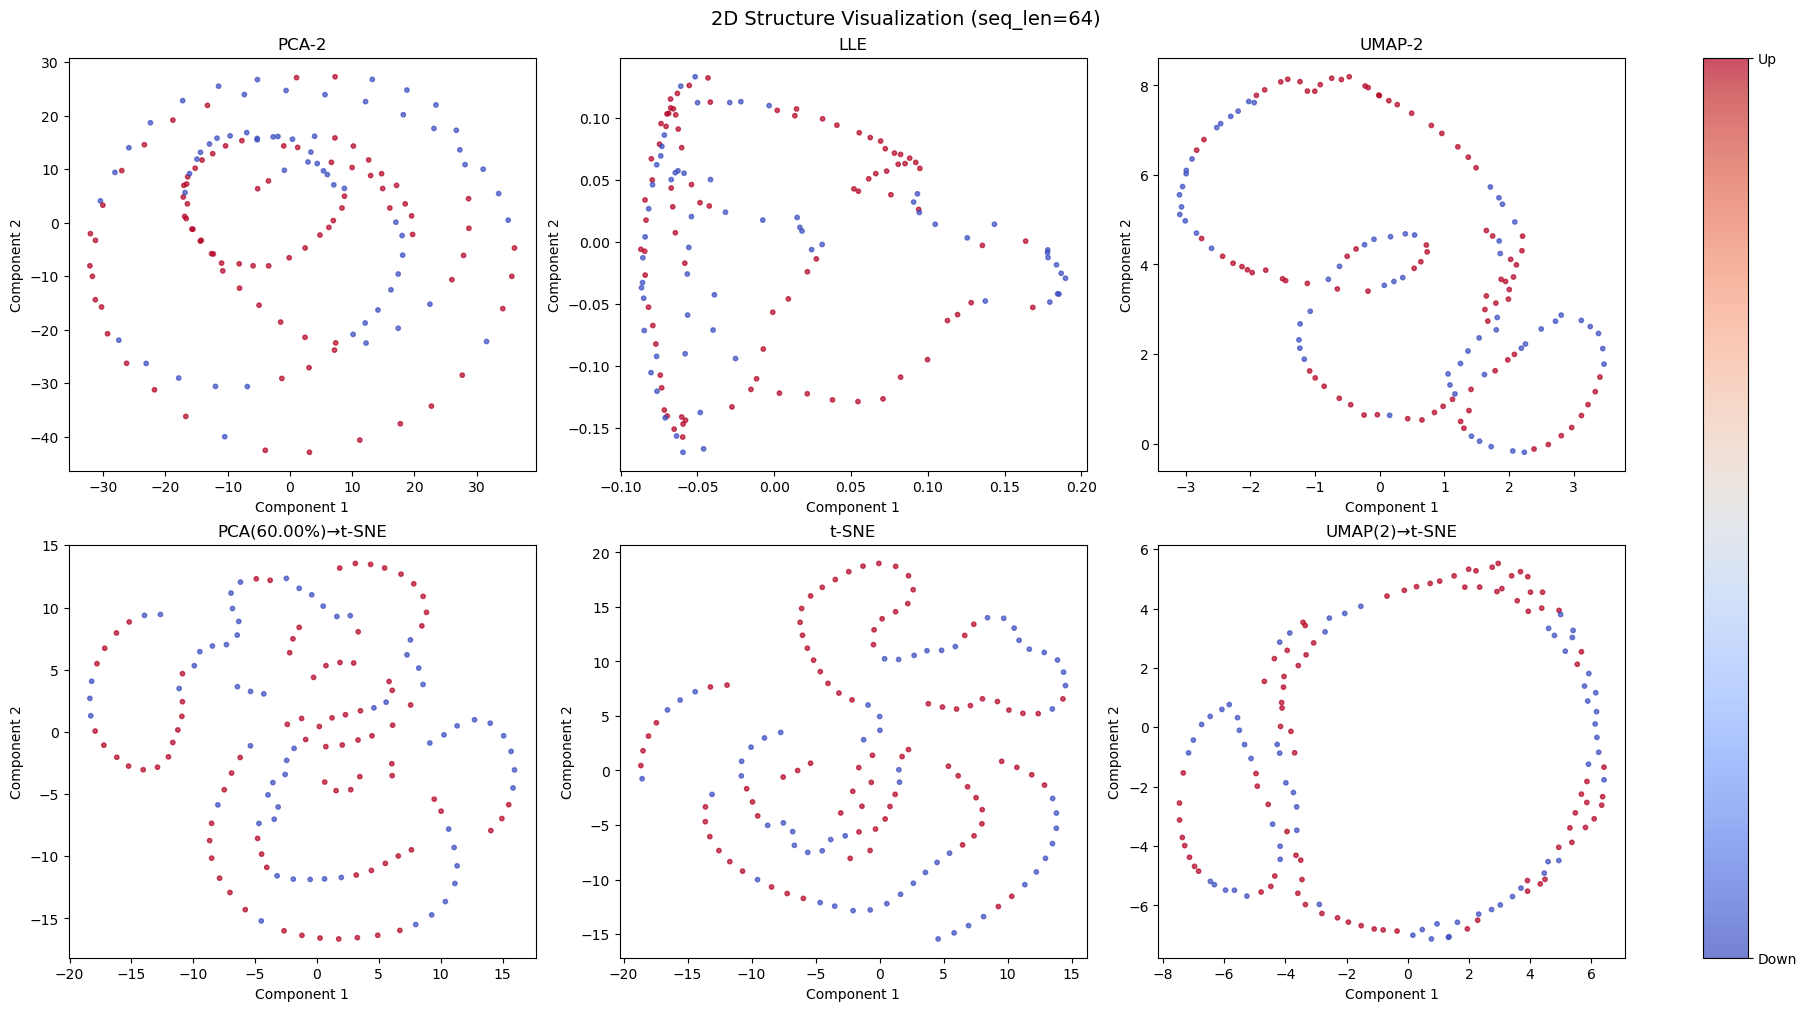

In [12]:
finfact.visualize_structure_2d (seq_len=64,
                                percentage=0.5,
                                perplexity=30,
                                n_neighbors=10,
                                random_state=42,
                                pca_evp=0.6,
                                umap_components=2
                                )

Clustering eval: 100%|██████████| 18/18 [00:00<00:00, 44.90it/s]


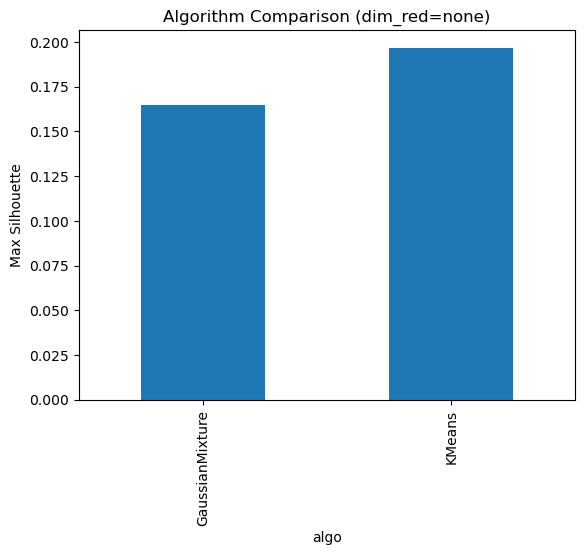

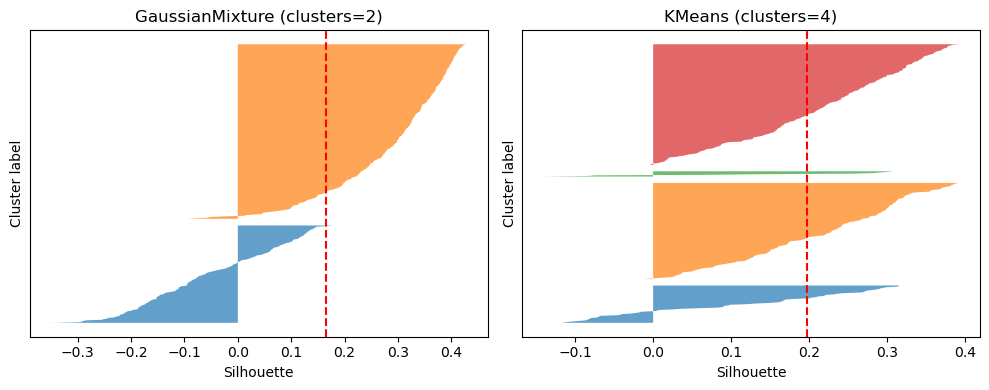

     algo  n_clusters  silhouette
0  KMeans         3.0    0.187613
1  KMeans         2.0    0.194249
2  KMeans         6.0    0.129037
3  KMeans         4.0    0.196825
4  KMeans         7.0    0.133693
5  KMeans         8.0    0.139577
6  KMeans         9.0    0.121060
7  KMeans        10.0    0.113404


In [9]:
cluster_df = finfact.evaluate_clusterings(algos=['KMeans','GaussianMixture'],
                                          metrics=['silhouette'],
                                          seq_len=1)
print(cluster_df[['algo','n_clusters','silhouette']].head(8))

In [ ]:
df_eval_report

In [ ]:
best_row = df_eval_report.loc[12]

In [ ]:
label_series = pd.Series(best_row['_labels'])
counts = label_series.value_counts()
print(counts)

#### IC分析

#### 相关性检测

In [ ]:
df_filtered = finfact.df_features.set_index('timestamp')

In [ ]:
corr = pd.DataFrame (df_filtered).corr ()
plt.figure (figsize=(12, 10))
sns.heatmap (corr, cmap='coolwarm', center=0)
plt.title ('Feature Correlation Matrix')
plt.show ()

#### PCA分析

In [ ]:
from sklearn.decomposition import PCA

pca = PCA ()
pca.fit (df_filtered)
percent = 0.99

cumulative = np.cumsum (pca.explained_variance_ratio_)
n_PCs = np.argmax (cumulative >= percent) + 1

print (f"前 {n_PCs} 个主成分累计解释了 {cumulative[n_PCs - 1]:.2%} 的方差")
feature_names = df_featured.columns

# 打印所有有重大贡献的主成分
for i in range (n_PCs):
    # 第 i 个主成分的系数
    pc = pca.components_[i]

    # 取绝对值最大的特征位置
    top_feature_idx = np.argmax (np.abs (pc))
    top_feature_name = feature_names[top_feature_idx]

    print (f"PC{i + 1} 的主导因子是: {top_feature_name}（贡献系数: {pc[top_feature_idx]:.4f}）")